In [1]:
import numpy as np
import pandas as pd

## Stanford Sentiment Treebank Data

I am working with SST for performing sentiment analysis while also using PyTorch and Pandas for hands on practice with those two tools. And build up my core NLP concepts.

### Dataset

I have two files `train.tsv` and `test.tsv` with columns as `(PhraseId, SentenceId, Phrase, Sentiment)`. 

The Sentiment values score range in `[0,4]`:
* 0 - Very negative
* 1 - Negative
* 2 - Neutral
* 3 - Positive
* 4 - Very Positive


In [2]:
train = pd.read_csv("./train.tsv", sep="\t")
test = pd.read_csv("./test.tsv", sep="\t")

In [3]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
print("Train samples:", train.shape[0])
print("Test samples:", test.shape[0])

Train samples: 156060
Test samples: 66292


In [5]:
print("Null values:\n", train.isnull().sum())

Null values:
 PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64


In [6]:
print("Sentinment distribution:\n")
disbn_df = pd.DataFrame(train["Sentiment"].value_counts().sort_index())
disbn_df.index.name = None
disbn_df.index = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
disbn_df

Sentinment distribution:



,count
Very Negative,7072
Negative,27273
Neutral,79582
Positive,32927
Very Positive,9206


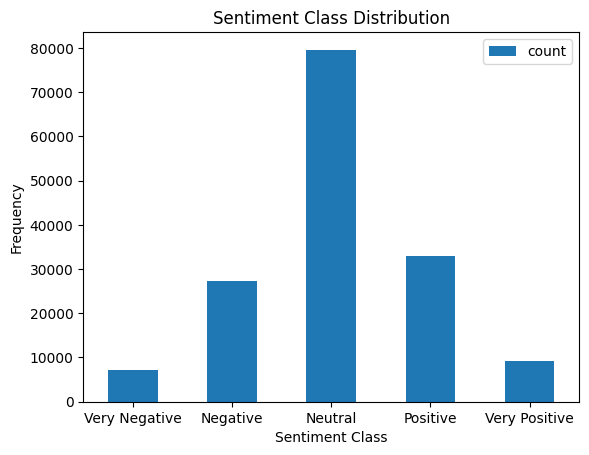

In [7]:
## Plotting the Sentiment distribution
import matplotlib.pyplot as plt

disbn_df.plot(kind='bar', title="Sentiment Class Distribution", xlabel="Sentiment Class", \
             ylabel="Frequency"
)
plt.xticks(rotation=0)
plt.show()

## Phrase length matters
We need to see how long the phrases are. Input length affects the model performance and memory usage.

We'll tokenize each phrase into words and count their lengths


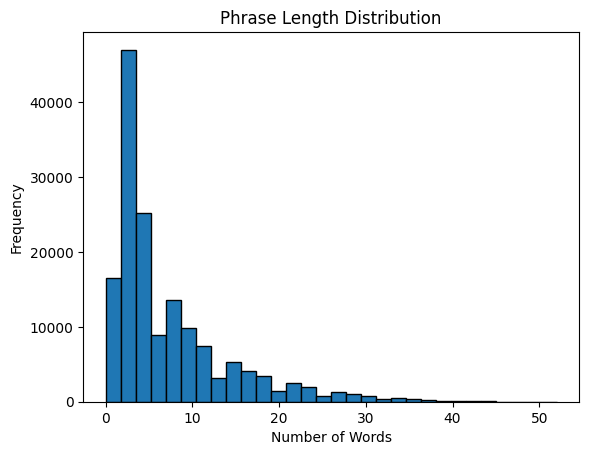

In [8]:
train['PhraseLength'] = train['Phrase'].apply(lambda x : len(x.split()))

train['PhraseLength'].plot(
    kind='hist', bins=30, title='Phrase Length Distribution', edgecolor='black'
)
plt.xlabel('Number of Words')
plt.show()

## Tokenization and Vocabulary

### Tokenization

The process of splitting a sentence or phrase into smaller units called **tokens** (usually words or `subwords`). 

ML models work with numbers not raw text. So in our NLP pipeline here we will break text into tokens and convert these tokens into numbers.

For example:-

`"Black Swan is a great movie"` will be tokenized into :-

```python
tokens = ["Black", "Swan", "is", "a", "great", "movie"]
```

I will make use of `nltk` library to use `word_tokenize`.

In [9]:
import nltk
from nltk.tokenize import word_tokenize

# downloaading tokenizer model
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [10]:
# tokenizing every `Phrase`

train['Tokens'] = train['Phrase'].apply(word_tokenize)

In [11]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,PhraseLength,Tokens
0,1,1,A series of escapades demonstrating the adage ...,1,37,"[A, series, of, escapades, demonstrating, the,..."
1,2,1,A series of escapades demonstrating the adage ...,2,14,"[A, series, of, escapades, demonstrating, the,..."
2,3,1,A series,2,2,"[A, series]"
3,4,1,A,2,1,[A]
4,5,1,series,2,1,[series]


### Vocabulary building

We have tokenized the text, now we need to create a vocabulary. It is a mapping from each token to a unique index. This will help us tune our text into a format that a neural network can work with.

We have some special tokens:-
* `<PAD>` for padding
* `<UNK>` for unknown words
* `<SOS>`/`<EOS>`

In [12]:
from collections import Counter

# we get all the tokens from the `Tokens` column
all_tokens = [token.lower() for tokens in train['Tokens'] for token in tokens]
token_freq = Counter(all_tokens)

In [13]:
# we can do a minimum frequency threshold to filter out tokens 
#(this is not necessary but let's just do it)
min_freq = 3
filtered_tokens = [token for token, freq in token_freq.items() if freq >= min_freq]

In [14]:
# Now we create a word-to-index dictionary

vocab = {'<PAD>': 0, '<UNK>': 1}
for idx, token in enumerate(filtered_tokens, start=2):
    vocab[token] = idx
    
print(f"Vocab size: {len(vocab)}")

Vocab size: 16408


### Converting tokens into sequences

we convert each phrase (our token list `Tokens`) into a sequence of numbers using the vocabulary we built. Any words that we did not encounter will fall back to `<UNK>` index (likely not to happen with train dataframe but might happen with test dataframe.

In [15]:
def tokens_to_indices(tokens, vocab):
    return [vocab.get(token.lower(), vocab['<UNK>']) for token in tokens]

# applying this to train dataframe
train['TokenIds'] = train['Tokens'].apply(lambda tokens: tokens_to_indices(tokens, vocab))

In [16]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,PhraseLength,Tokens,TokenIds
0,1,1,A series of escapades demonstrating the adage ...,1,37,"[A, series, of, escapades, demonstrating, the,...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 7, 14..."
1,2,1,A series of escapades demonstrating the adage ...,2,14,"[A, series, of, escapades, demonstrating, the,...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 7, 14]"
2,3,1,A series,2,2,"[A, series]","[2, 3]"
3,4,1,A,2,1,[A],[2]
4,5,1,series,2,1,[series],[3]


### Padding sequences

We need to make the phrases same length when batching.

We will **pad shorter sequences** with `<PAD>` token (0 index).

We choose `max_len` for tokens and truncate/pad accordingly

In [17]:
import torch
max_len = 20

def pad_sequence(seq, max_len):
    if len(seq) < max_len:
        return seq + [vocab['<PAD>']] * (max_len - len(seq))
    else:
        return seq[:max_len]
    
## Applying the padding
train['PaddedTokenIds'] = train['TokenIds'].apply(lambda x: pad_sequence(x, max_len))

In [18]:
## we convert the PaddedTokenIds and Sentiment to tensors

X = torch.tensor(train['PaddedTokenIds'].tolist(), dtype=torch.long)
target = torch.tensor(train['Sentiment'].tolist(), dtype=torch.long)

print("X size:", X.shape)
print("target size:", target.shape)

X size: torch.Size([156060, 20])
target size: torch.Size([156060])


## Model Building

We are going to use LSTM. Why are we using it?

NLP involves using sequences and the meaning of a word often depends on the words that are around it.
For example:-

<span style="background-color:#f6f8fa;padding: 1px 15px 1px 15px;">Black Swan was a good movie."</span>

vs

<span style="background-color:#f6f8fa;padding: 1px 15px 1px 15px;">Black Swan was a <b>really</b> good movie."</span>

- RNNs were first DL models to process sequences but they struggle with vanishing gradient problems or to process long dependencies.

- LSTM networks shine here - they make use of **gates** to retain and forget information over time


### Model architecture

I will build a basic sentiment classifier. It will compose of:-
* **Embedding Layer** - Will turn token ids into dense vectors
* **LSTM Layer** - process the sequence
* **FCL** - fully connected layer will output sentiment class logits
* **Softmax + CELoss**- for multi-class classification


In [19]:
from torch.utils.data import Dataset, DataLoader

class SSTDataset(Dataset):
    def __init__(self, input_tensor, target_tensor):
        self.inputs = input_tensor
        self.targets = target_tensor
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
    
# create our dataset and dataloader
dataset = SSTDataset(X, target)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [20]:
## Now we create our LSTM model

import torch.nn as nn

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        last_hidden = hidden.squeeze(0)
        logits = self.fc(last_hidden)
        return logits

In [21]:
## setting hyperparamters

vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 128
output_dim = 5 # we have 5 sentiment classes [0,4]

model = SentimentLSTM(vocab_size, embed_dim, hidden_dim, output_dim)

### Loss and Optimization

* `CrossEntropyLoss` - combines LogSoftmax + NLL Loss
* `Adam` optimizer - it adapts learning rate for each parameter

In [22]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [23]:
device

device(type='cuda')

In [25]:
## Train looop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # calculating accuracy
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
    
    acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f} - Accuracy: {acc:.4f}")

Epoch 1/10 - Loss: 2708.0496 - Accuracy: 0.5591
Epoch 2/10 - Loss: 2122.6706 - Accuracy: 0.6517
Epoch 3/10 - Loss: 1865.8696 - Accuracy: 0.6915
Epoch 4/10 - Loss: 1711.2446 - Accuracy: 0.7153
Epoch 5/10 - Loss: 1596.0039 - Accuracy: 0.7316
Epoch 6/10 - Loss: 1497.7980 - Accuracy: 0.7481
Epoch 7/10 - Loss: 1408.6224 - Accuracy: 0.7622
Epoch 8/10 - Loss: 1321.4483 - Accuracy: 0.7760
Epoch 9/10 - Loss: 1239.6439 - Accuracy: 0.7893
Epoch 10/10 - Loss: 1161.6966 - Accuracy: 0.8021


In [26]:
from sklearn.model_selection import train_test_split

# Split into 80% train and 20% validation
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    X, target, test_size=0.2, random_state=42, stratify=target
)

# Wrap into DataLoaders
train_loader = DataLoader(SSTDataset(train_inputs, train_targets), batch_size=64, shuffle=True)
val_loader = DataLoader(SSTDataset(val_inputs, val_targets), batch_size=64)


In [27]:
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == targets).sum().item()
        total += targets.size(0)

    train_acc = correct / total

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            val_correct += (preds == targets).sum().item()
            val_total += targets.size(0)

    val_acc = val_correct / val_total
    print(f"Epoch {epoch+1}: Train Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1: Train Loss: 856.8430 | Train Acc: 0.8160 | Val Acc: 0.8072
Epoch 2: Train Loss: 777.4803 | Train Acc: 0.8337 | Val Acc: 0.7870
Epoch 3: Train Loss: 709.0539 | Train Acc: 0.8482 | Val Acc: 0.7684
Epoch 4: Train Loss: 652.4488 | Train Acc: 0.8608 | Val Acc: 0.7611
Epoch 5: Train Loss: 592.6912 | Train Acc: 0.8731 | Val Acc: 0.7488
Epoch 6: Train Loss: 547.7602 | Train Acc: 0.8847 | Val Acc: 0.7412
Epoch 7: Train Loss: 500.8785 | Train Acc: 0.8946 | Val Acc: 0.7332
Epoch 8: Train Loss: 461.4341 | Train Acc: 0.9032 | Val Acc: 0.7259
Epoch 9: Train Loss: 423.6345 | Train Acc: 0.9122 | Val Acc: 0.7225
Epoch 10: Train Loss: 397.0383 | Train Acc: 0.9185 | Val Acc: 0.7217


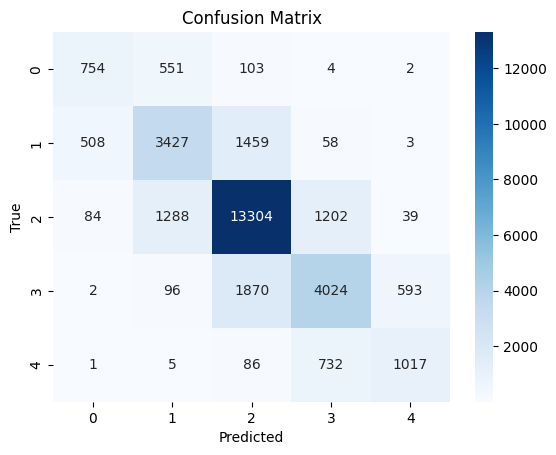

Classification Report:
               precision    recall  f1-score   support

           0      0.559     0.533     0.546      1414
           1      0.639     0.628     0.633      5455
           2      0.791     0.836     0.813     15917
           3      0.668     0.611     0.638      6585
           4      0.615     0.552     0.582      1841

    accuracy                          0.722     31212
   macro avg      0.654     0.632     0.642     31212
weighted avg      0.718     0.722     0.719     31212



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1 Score
report = classification_report(all_targets, all_preds, digits=3)
print("Classification Report:\n", report)
